<a href="https://colab.research.google.com/github/komh9575/first-repository/blob/main/%EC%8A%A4%ED%83%80%EB%B2%85%EC%8A%A4%20%EC%8B%A4%EC%8A%B5%ED%8C%8C%EC%9D%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 머신러닝 & 시각화
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import shap

%matplotlib inline
print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


In [22]:
import koreanize_matplotlib
from datetime import timedelta


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 32.5 MB/s eta 0:00:00


# Part 1: 프로덕트 분석, RFM 분석 및 고객 세그멘테이션
## 학습목표
- **고객 세분화**
    - RFM 분석 및 K-Means Clustering을 통해 고객을 유의미한 그룹으로 분류하고 페르소나를 정의합니다.
- **리텐션 및 전환 분석**
    - **코호트 분석**을 통해 고객 유지율을 파악하고, **퍼널 분석**을 통해 구매 여정의 병목 구간을 발굴합니다.
- **행동 예측**
    - 머신러닝 알고리즘을 활용하여 고객의 이탈 가능성(Churn)을 예측합니다.
- **전략 수립**
    - 분석 결과를 바탕으로 마케팅, CRM, 프로덕트 개선 등 실질적인 비즈니스 전략을 제안합니다.

    ### 분석 및 모델링

*데이터셋의 특성에 따라 분석 기법의 구체적인 적용 방식은 달라질 수 있습니다.*

## 분석 흐름
1. **데이터 수집 및 이해:** 데이터셋 컬럼 의미 파악 및 타입 확인.
2. **데이터 전처리:** 결측치/이상치 처리, 날짜 데이터 변환.
3. **탐색적 데이터 분석 (EDA):** 매출 추이, 상품별 순위 등 기초 통계 확인.
4. **심화 분석 (Deep Dive):**
    - **RFM & Clustering:** 고객 등급 분류.
    - **Cohort Analysis:** 월별 코호트 재구매율 히트맵 작성.
    - **Funnel Analysis:** (데이터에 로그가 부족할 경우, '상품 조회 수 대비 구매 건수' 등으로 간소화하여 진행 가능).
5. **예측 모델링 (Prediction):** 이탈 예측 모델 학습 및 성능 평가.
6. **결론 도출:** 분석 내용을 종합하여 마케팅/기획 전략 제안.

In [25]:
df=pd.read_json('/content/portfolio.json', lines=True)
display(df.head())

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [24]:
display(df.tail())

,reward,channels,difficulty,duration,offer_type,id
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [26]:
print("데이터 크기:", df.shape)
print("\n데이터 타입:")
print(df.dtypes)
print("\n결측치 개수:")
print(df.isnull().sum())

데이터 크기: (10, 6)

데이터 타입:
reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

결측치 개수:
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64


In [27]:
df.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [28]:
df.describe(include='object')

,channels,offer_type,id
count,10,10,10
unique,4,3,10
top,"[web, email, mobile, social]",bogo,ae264e3637204a6fb9bb56bc8210ddfd
freq,4,4,1


In [33]:
df=pd.read_json('/content/profile.json', lines=True)
display(df.head())

print("\n")
display(df.tail())


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


,gender,age,id,became_member_on,income
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0
16999,F,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0


In [35]:
print("데이터 크기:", df.shape)
print("\n데이터 타입:")
print(df.dtypes)
print("\n결측치 개수:")
print(df.isnull().sum())

데이터 크기: (306534, 4)

데이터 타입:
person    object
event     object
value     object
time       int64
dtype: object

결측치 개수:
person    0
event     0
value     0
time      0
dtype: int64


In [39]:
df.describe()
df.describe(include='object')

,person,event,value
count,306534,306534,306534
unique,17000,4,5121
top,94de646f7b6041228ca7dec82adb97d2,transaction,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
freq,51,138953,14983


In [34]:
df=pd.read_json('/content/transcript.json', lines=True)
display(df.head())

print("\n")
display(df.tail())

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [36]:
print("데이터 크기:", df.shape)
print("\n데이터 타입:")
print(df.dtypes)
print("\n결측치 개수:")
print(df.isnull().sum())

데이터 크기: (306534, 4)

데이터 타입:
person    object
event     object
value     object
time       int64
dtype: object

결측치 개수:
person    0
event     0
value     0
time      0
dtype: int64


In [37]:
df.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [38]:
df.describe(include='object')

,person,event,value
count,306534,306534,306534
unique,17000,4,5121
top,94de646f7b6041228ca7dec82adb97d2,transaction,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
freq,51,138953,14983


## 데이터 전처리

1. 포트폴리오에 있는 id -> person_id으로 변경
- person_id 중복 검증
- person_id 기준 중복 행 존재 여부 확인
2. gender : None → 'Unknown'
- gender 값이 M, F, Unknown othet(기타)로만 구성되는지 확인
- 소문자/대문자, 공백 등 이상값 제거
- 범주형 변수로 명확히 고정
3. age 118 → NaN → 중앙값 변경
- age 파생 변수 생성
- 정제된 age를 기준으로 연령대 구간 생성
(예: 18–29, 30–39, 40–49, 50–59, 60+)
새로운 컬럼: age_group
4. became_member_on → datetime
- membership_days 파생 변수 추가
membership_days를 구간화한 변수 생성
(예: <1년, 1–3년, 3년 이상)
컬럼 예: membership_group
- membership_days 이상치 처리
- 상위 1% 또는 99% 기준으로 클리핑
5. 기준일 − 가입일 → membership_days 변수 생성
6.income 대체 결과 검증
- income 중앙값 대체 후에도 NaN이 남아 있는지 확인
- income_is_missing = 1인 행과 0인 행의 분포 비교
- 소득이 실제값인지 추정값인지 구분 가능하도록 플래그 유지
- income 이상치 처리
- income 상·하위 극단값 점검
- 필요 시 상위 1% 기준으로 클리핑

In [40]:
# 1. 포트폴리오에 있는 id -> person_id으로 변경
# 프로파일에 있는 id -> person_id으로 변경
# transcipt에 있는 person을 person_id로 변경
# person_id 중복 검증
# person_id 기준 중복 행 존재 여부 확인

In [41]:
portfolio_df = pd.read_json('/content/portfolio.json', lines=True)
portfolio_df.rename(columns={'id': 'person_id'}, inplace=True)
print(f"Number of duplicate 'person_id' values in portfolio_df: {portfolio_df['person_id'].duplicated().sum()}")
print(f"Number of duplicate rows based on 'person_id' in portfolio_df: {portfolio_df.duplicated(subset=['person_id']).sum()}")
portfolio_df.head()

Number of duplicate 'person_id' values in portfolio_df: 0
Number of duplicate rows based on 'person_id' in portfolio_df: 0


,reward,channels,difficulty,duration,offer_type,person_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [42]:
profile_df = pd.read_json('/content/profile.json', lines=True)
profile_df.rename(columns={'id': 'person_id'}, inplace=True)
print(f"Number of duplicate 'person_id' values in profile_df: {profile_df['person_id'].duplicated().sum()}")
print(f"Number of duplicate rows based on 'person_id' in profile_df: {profile_df.duplicated(subset=['person_id']).sum()}")
profile_df.head()

Number of duplicate 'person_id' values in profile_df: 0
Number of duplicate rows based on 'person_id' in profile_df: 0


,gender,age,person_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [43]:
transcript_df = pd.read_json('/content/transcript.json', lines=True)
transcript_df.rename(columns={'person': 'person_id'}, inplace=True)
print(f"Number of duplicate 'person_id' values in transcript_df: {transcript_df['person_id'].duplicated().sum()}")
print(f"Number of duplicate rows based on 'person_id' in transcript_df: {transcript_df.duplicated(subset=['person_id']).sum()}")
transcript_df.head()

Number of duplicate 'person_id' values in transcript_df: 289534
Number of duplicate rows based on 'person_id' in transcript_df: 289534


,person_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


- id 컬럼을 person_id로 변경
- id 컬럼을 person_id로 변경
- person 컬럼을 person_id로 변경

In [44]:
# gender: None 값을 '알 수 없음'으로 변경
profile_df['gender'].fillna('알 수 없음', inplace=True)

# 소문자/대문자, 공백 등 이상값 제거 및 표준화 (예: 모두 대문자로 변환)
profile_df['gender'] = profile_df['gender'].astype(str).str.strip().str.upper()

# 범주형 변수로 명확히 고정
profile_df['gender'] = pd.Categorical(profile_df['gender'])

# 변경된 gender 값 확인
print("Gender 값 분포:")
display(profile_df['gender'].value_counts())
print("Gender 데이터 타입:", profile_df['gender'].dtype)

Gender 값 분포:


,count
gender,
M,8484
F,6129
알 수 없음,2175
O,212


Gender 데이터 타입: category


In [45]:
import numpy as np

# age 118을 NaN으로 변경
profile_df['age'] = profile_df['age'].replace(118, np.nan)

# 연령대 구간 정의
bins = [18, 30, 40, 50, 60, profile_df['age'].max() + 1]
labels = ['18-29', '30-39', '40-49', '50-59', '60+']

# age_group 컬럼 생성
profile_df['age_group'] = pd.cut(profile_df['age'], bins=bins, labels=labels, right=False)

# 변경된 age 및 age_group 값 확인
print("Age 값에 118이 NaN으로 변경되었는지 확인 (처음 5개 행):")
display(profile_df[['age', 'age_group']].head())

print("\nAge_group 분포:")
display(profile_df['age_group'].value_counts().sort_index())

Age 값에 118이 NaN으로 변경되었는지 확인 (처음 5개 행):


,age,age_group
0,NaN,NaN
1,55.0,50-59
2,NaN,NaN
3,75.0,60+
4,NaN,NaN



Age_group 분포:


,count
age_group,
18-29,1574
30-39,1526
40-49,2309
50-59,3541
60+,5875


In [46]:
# became_member_on -> datetime으로 변경
profile_df['became_member_on'] = pd.to_datetime(profile_df['became_member_on'], format='%Y%m%d')

# 기준일 설정 (데이터 내 가장 최근 가입일 또는 분석 기준일)
# 여기서는 데이터 내 가장 최근 가입일을 기준으로 설정
reference_date = profile_df['became_member_on'].max()

# membership_days 파생 변수 추가
profile_df['membership_days'] = (reference_date - profile_df['became_member_on']).dt.days

# membership_days를 구간화한 변수 생성
bins_membership = [-1, 365, 365*3, profile_df['membership_days'].max() + 1]
labels_membership = ['<1년', '1-3년', '3년 이상']
profile_df['membership_group'] = pd.cut(profile_df['membership_days'], bins=bins_membership, labels=labels_membership, right=False)

# membership_days 이상치 처리 (상위 1% 또는 99% 기준으로 클리핑)
upper_bound = profile_df['membership_days'].quantile(0.99)
profile_df['membership_days'] = np.where(profile_df['membership_days'] > upper_bound, upper_bound, profile_df['membership_days'])

# 변경된 컬럼 확인
print("Became_member_on, membership_days, membership_group 확인 (처음 5개 행):")
display(profile_df[['became_member_on', 'membership_days', 'membership_group']].head())

print("\nMembership Group 분포:")
display(profile_df['membership_group'].value_counts().sort_index())

Became_member_on, membership_days, membership_group 확인 (처음 5개 행):


,became_member_on,membership_days,membership_group
0,2017-02-12,529.0,1-3년
1,2017-07-15,376.0,1-3년
2,2018-07-12,14.0,<1년
3,2017-05-09,443.0,1-3년
4,2017-08-04,356.0,<1년



Membership Group 분포:


,count
membership_group,
<1년,8691
1-3년,6924
3년 이상,1385


income 컬럼에 남아있는 NaN 개수: 0

Income 분포 비교 (income_is_missing == 0):


,income
count,14825.000000
mean,65404.991568
std,21598.299410
min,30000.000000
25%,49000.000000
50%,64000.000000
75%,80000.000000
max,120000.000000



Income 분포 비교 (income_is_missing == 1): - 중앙값으로 대체된 값 포함


,income
count,2175.0
mean,64000.0
std,0.0
min,64000.0
25%,64000.0
50%,64000.0
75%,64000.0
max,64000.0


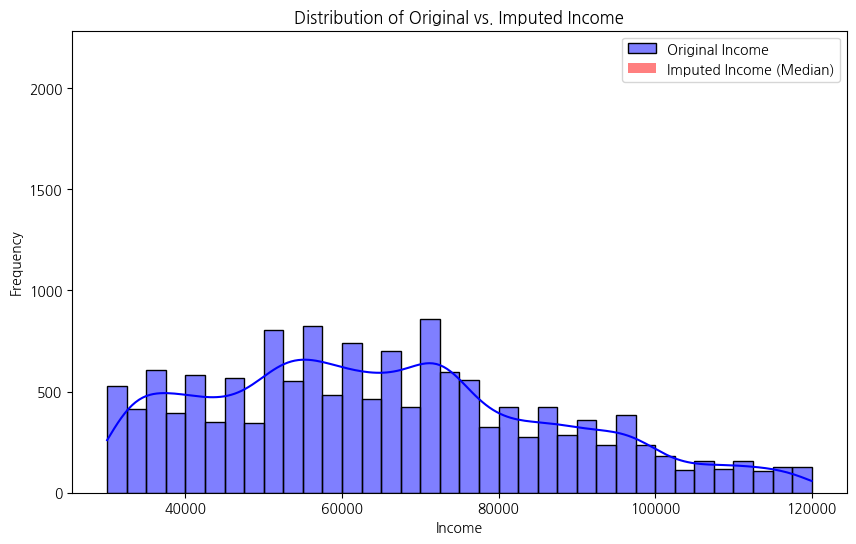


Income 상위 1% 클리핑 후 최대값: 116000.0

Income 전처리 결과 확인 (처음 5개 행):


,income,income_is_missing
0,64000.0,1
1,112000.0,0
2,64000.0,1
3,100000.0,0
4,64000.0,1


In [47]:
# 1. income_is_missing 플래그 생성
profile_df['income_is_missing'] = profile_df['income'].isnull().astype(int)

# 2. income 중앙값 대체
median_income = profile_df['income'].median()
profile_df['income'].fillna(median_income, inplace=True)

# 3. income 중앙값 대체 후에도 NaN이 남아 있는지 확인
print(f"income 컬럼에 남아있는 NaN 개수: {profile_df['income'].isnull().sum()}")

# 4. income_is_missing = 1인 행과 0인 행의 분포 비교
print("\nIncome 분포 비교 (income_is_missing == 0):")
display(profile_df[profile_df['income_is_missing'] == 0]['income'].describe())

print("\nIncome 분포 비교 (income_is_missing == 1): - 중앙값으로 대체된 값 포함")
display(profile_df[profile_df['income_is_missing'] == 1]['income'].describe())

# 시각화를 통해 분포 비교 (선택 사항)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(profile_df[profile_df['income_is_missing'] == 0]['income'], color='blue', label='Original Income', kde=True)
sns.histplot(profile_df[profile_df['income_is_missing'] == 1]['income'], color='red', label='Imputed Income (Median)', kde=True)
plt.title('Distribution of Original vs. Imputed Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 5. income 이상치 처리 (상위 1% 기준으로 클리핑)
upper_bound_income = profile_df['income'].quantile(0.99)
profile_df['income'] = np.where(profile_df['income'] > upper_bound_income, upper_bound_income, profile_df['income'])

print(f"\nIncome 상위 1% 클리핑 후 최대값: {profile_df['income'].max()}")

# 변경된 컬럼 확인 (처음 5개 행)
print("\nIncome 전처리 결과 확인 (처음 5개 행):")
display(profile_df[['income', 'income_is_missing']].head())